In [1]:
p = np.array([math.sin(x/2)+x/16 for x in range(30)]) + 3# + (np.random.random(L)-0.5)*2
p = torch.from_numpy(p.astype(np.float32))*10
dp = p[1:] - p[:-1]
hold = compute_hold(p)
plt.plot(p, ".-")
plt.plot(hold)
plt.plot(dp)

fsize = 3
features = []
for i in range(p.shape[0]):
    if i < fsize-1:
        features.append(torch.zeros(fsize))
    else:
        features.append(p[i-fsize+1:i+1] - p[i])

features = torch.vstack(features)
for i in range(fsize-1, 10):
    plt.plot(range(i-fsize+1, i+1), features[i].numpy())
plt.grid("on")
plt.tight_layout()

NameError: name 'np' is not defined

In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import PyConfig
from data_processing.train_dataset import next_price_prediction
from tqdm import tqdm
from ml.models import autoregress_sequense, E2EModel
from e2e_train import E2ETrain
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from backtest import backtest
from loguru import logger

%reload_ext autoreload
%autoreload 2

logger.remove()
logger.add(sys.stderr, level="DEBUG")

def save_model(model):
    model.eval()
    example = torch.rand((1,) + model.inp_shape)
    model_jit = torch.jit.trace(model, example)
    model_jit.save("model.pt")

    # torch.save(model, "model.pt")

In [8]:
DEVICE = torch.device("cpu")
cfg = PyConfig("zz.py").test()
cfg.date_end = "2020.01.01"
# cfg.date_start = "2020.01.01"

In [9]:
e2e_train = E2ETrain(cfg)
e2e_train.load_data()

2024-08-07 16:53:14.012 | WARNING  | data_processing.dataloading:__init__:276 - Not enough history, shift start id from 0 to 128
2024-08-07 16:53:14.013 | WARNING  | data_processing.dataloading:__init__:279 - Switch to 2000-02-02 11:00:00
2024-08-07 16:53:14.013 | INFO     | data_processing.dataloading:__call__:306 - Start generate data from 2000-01-01 00:00:00128 to 2020-01-01 00:00:0043186
2024-08-07 16:53:26.495 | INFO     | data_processing.train_dataset:next_price_prediction:17 - Generated features shape: (1648, 16), and prices shape: (1648,)


In [11]:
model = e2e_train.train(num_epochs=1000, 
                        resume=False,
                        device=DEVICE)

2024-08-07 16:59:36.592 | DEBUG    | e2e_train:init_model:23 - 
Loaded model summary:
2024-08-07 16:59:36.594 | DEBUG    | e2e_train:init_model:24 - ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
E2EModel                                 [1, 1]                    272
├─LayerNorm: 1-1                         [1, 16]                   32
├─Linear: 1-2                            [1, 16]                   272
├─InstanceNorm1d: 1-3                    [1, 16]                   --
├─ReLU: 1-4                              [1, 16]                   --
├─Linear: 1-5                            [1, 1]                    17
├─Tanh: 1-6                              [1, 1]                    --
Total params: 593
Trainable params: 593
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estima

In [13]:
cfg_test = PyConfig("zz.py").test()
cfg_test.date_start = "2020.01.01"
e2e_train = E2ETrain(cfg_test)
e2e_train.load_data()

2024-08-07 17:12:38.336 | INFO     | data_processing.dataloading:__call__:306 - Start generate data from 2020-01-01 00:00:0043186 to 2024-08-01 00:00:0055953
2024-08-07 17:12:41.983 | INFO     | data_processing.train_dataset:next_price_prediction:17 - Generated features shape: (461, 16), and prices shape: (461,)


/home/pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/instancenorm.py:88: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


<BarContainer object of 461 artists>

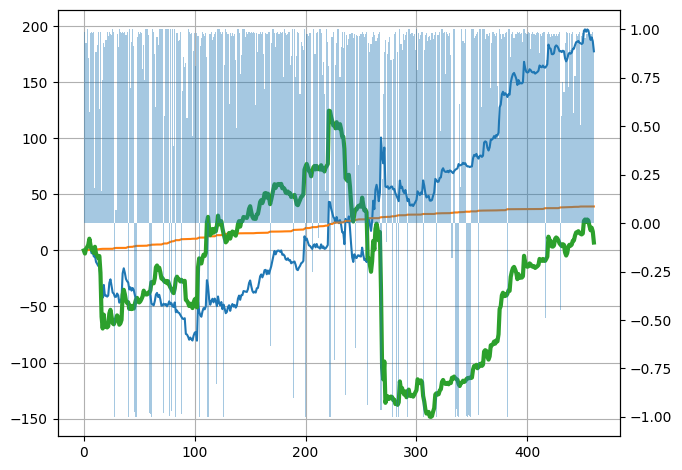

In [14]:
model.eval()
output_seq, result_seq, fee_seq = autoregress_sequense(model, e2e_train.p, e2e_train.features, output_sequense=True, device=DEVICE)

fig, ax1 = plt.subplots()
# ax1.plot(p - p[0], linewidth=3)
ax1.plot(result_seq.cumsum(0))
ax1.plot(fee_seq.cumsum(0))
ax1.plot(e2e_train.compute_hold(), linewidth=3)
ax1.grid("on")
plt.tight_layout()
plt.grid("on")

ax2 = ax1.twinx()
ax2.bar(list(range(output_seq.shape[0])), height=output_seq, width=1, alpha=0.4)

In [10]:
with torch.no_grad():   
    model = torch.load("model.pt")
    output = model(torch.from_numpy(e2e_train.features[300:301]))
output

tensor([[0.7836]])

In [13]:
years[19:]

['2019-12-31T00:00:00',
 '2020-12-31T00:00:00',
 '2021-12-31T00:00:00',
 '2022-12-31T00:00:00',
 '2023-12-31T00:00:00']

2024-08-07 14:13:11.004 | WARNING  | data_processing.dataloading:__init__:276 - Not enough history, shift start id from 0 to 128
2024-08-07 14:13:11.005 | WARNING  | data_processing.dataloading:__init__:279 - Switch to 2000-02-02 11:00:00
2024-08-07 14:13:11.005 | INFO     | data_processing.dataloading:__call__:306 - Start generate data from 2000-01-01 00:00:00128 to 2019-12-31 00:00:0043186
2024-08-07 14:13:24.232 | INFO     | data_processing.train_dataset:next_price_prediction:17 - Generated features shape: (3217, 8), and prices shape: (3217,)
/home/pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/instancenorm.py:88: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
Training: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]
/home/pc/miniconda3/lib/python3.12/site-packages/torch/

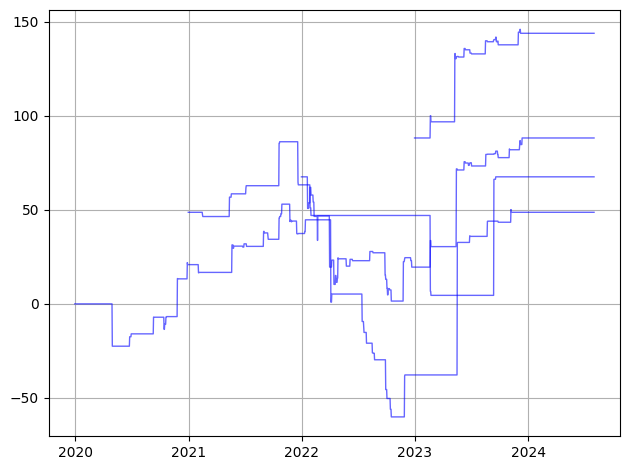

In [16]:
DEVICE = torch.device("cpu")

cfg = PyConfig("zz.py").test()
date_start = datetime.strptime(cfg.date_start, '%Y-%m-%dT%H:%M:%S').strftime('%m/%d/%Y')
date_end = datetime.strptime(cfg.date_end, '%Y-%m-%dT%H:%M:%S').strftime('%m/%d/%Y')

years = [pd.to_datetime(d).date().strftime('%Y-%m-%dT%H:%M:%S') for d in 
         pd.date_range(start=date_start, end=date_end, freq="Y")]

date_start = cfg.date_start
last_prof = 0
for year in years[19:-1]:
    cfg = PyConfig("zz.py").test()
    cfg.date_end = year
    e2e_train = E2ETrain(cfg)
    e2e_train.load_data()
    model = e2e_train.train(num_epochs=200, resume=False, device=DEVICE)
    save_model(model)
    
    cfg = PyConfig("zz.py").test()
    cfg.date_start = year
    brok_results = backtest(cfg)

    plt.plot(brok_results.daily_hist.days, brok_results.daily_hist.profit + last_prof, linewidth=1, color="b", alpha=0.6)
    last_prof += brok_results.final_profit
    plt.grid("on")
    plt.tight_layout()
    # legend.append(f"{cfg.date_start}-{cfg.date_end}")

In [21]:
brok_results = backtest(cfg)


2024-08-07 12:58:48.969 | ERROR    | data_processing.dataloading:__init__:268 - Date start 2024-08-01 00:00:00 is equal or higher than latest range date 2023-12-13 23:00:00


ValueError: 